In [41]:
pip install --upgrade -q git+https://github.com/huggingface/transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [42]:
pip install --upgrade -q git+https://github.com/facebookresearch/segment-anything

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


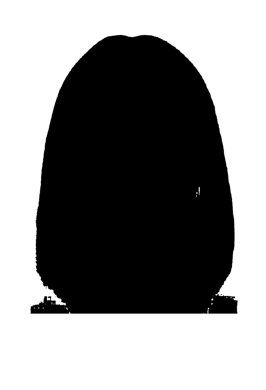

In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from transformers import SamModel, SamProcessor

# --- CARGAR MODELOS ---
clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")

sam_model = SamModel.from_pretrained("facebook/sam-vit-base")
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# --- CARGAR IMAGEN LOCAL ---
image_path = "../data/5_image_women_fringe.jpg"
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)

# --- CLIPSeg: segmentar "hair" ---
prompt = "hair ans fringe"
inputs_clipseg = clipseg_processor(text=prompt, images=image, return_tensors="pt")
with torch.no_grad():
    outputs_clipseg = clipseg_model(**inputs_clipseg)

pred_mask = torch.sigmoid(outputs_clipseg.logits)[0].squeeze().cpu().numpy()
binary_mask = (pred_mask > 0.5).astype("uint8")
resized_mask = cv2.resize(binary_mask, image.size)  # a tamaño original

# --- Bounding box del cabello ---
ys, xs = np.where(resized_mask == 1)
if len(xs) == 0 or len(ys) == 0:
    raise ValueError("CLIPSeg no detectó cabello con ese prompt.")
x_min, x_max = np.min(xs), np.max(xs)
y_min, y_max = np.min(ys), np.max(ys)

# Margen de seguridad
margin = 10
x_min = max(x_min - margin, 0)
x_max = min(x_max + margin, image.size[0])
y_min = max(y_min - margin, 0)
y_max = min(y_max + margin, image.size[1])

# --- Recortar imagen y calcular punto central dentro del recorte ---
cropped_image = image.crop((x_min, y_min, x_max, y_max))
crop_np = np.array(cropped_image)

# Punto central del recorte
h_crop, w_crop = crop_np.shape[:2]
x_center_crop = w_crop // 2
y_center_crop = h_crop // 2

# --- SAM sobre el recorte ---
input_points = [[[x_center_crop, y_center_crop]]]
input_labels = [[1]]  # foreground

inputs_sam = sam_processor(cropped_image, input_points=input_points, input_labels=input_labels, return_tensors="pt")
with torch.no_grad():
    outputs_sam = sam_model(**inputs_sam)

masks = sam_processor.image_processor.post_process_masks(
    outputs_sam.pred_masks, inputs_sam["original_sizes"], inputs_sam["reshaped_input_sizes"]
)

refined_crop_mask = masks[0][0].cpu().numpy()

# Si tiene 3 canales, tomar solo uno
if refined_crop_mask.ndim == 3 and refined_crop_mask.shape[0] == 3:
    refined_crop_mask = refined_crop_mask[0]

# Asegurar que sea 2D
refined_crop_mask = np.squeeze(refined_crop_mask)

# Binarizar (invertido)
refined_crop_mask = (refined_crop_mask > 0.5).astype("float32")

# --- Reconstruir máscara completa con fondo blanco ---
final_mask = np.ones((image.size[1], image.size[0]), dtype="float32")  # (H, W)
final_mask[y_min:y_max, x_min:x_max] = 1.0 - refined_crop_mask  # cabello en negro

# --- VISUALIZACIÓN ---
plt.figure(figsize=(12, 4))
plt.imshow(final_mask, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

final_mask_img = (final_mask * 255).astype("uint8")  # Escalar a 0–255
Image.fromarray(final_mask_img).save("../data/5_mask_clipseg+sam.png")